<a href="https://colab.research.google.com/github/kiranikram/gym/blob/master/RL_Optimization_50x50_with_maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/custom_gym/Nyc_maze/custom_env_dir/envs')

In [0]:
import gym
from gym import spaces
import matplotlib.pyplot as plt
from abc import ABC
from abc import abstractmethod
#from gym_pull.envs.registration import registry, register, make, spec
import numpy as np
from gym.utils import seeding
from PIL import Image
from skimage.draw import rectangle
from collections import namedtuple
from custom_env import NycMaze1
import sys
from contextlib import closing
from six import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np
from IPython.display import clear_output
from IPython.display import display
from time import sleep
import matplotlib.image as image

In [0]:
#Actions = {'North': 0, 'South': 1, 'East': 2, 'West': 3}

In [0]:
from gym import Env, spaces
from gym.utils import seeding
class environment(Env):
  def __init__(self, nS, nA, P, isd, start_state):
    # nS = number of States
    # na = Number of actions
    # P = transitions 
    # isd = initial state distribution 
    self.start_state = start_state
    self.s = start_state #change tis later to random 🤔
    self.P = P
    self.isd = isd
    self.lastaction = None
    self.nS = nS
    self.nA = nA

    self.action_space = spaces.Discrete(self.nA)
    self.observation_space = spaces.Discrete(self.nS)
    self.seed()

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def reset(self):
    raise NotImplementedError

  def step(self, a):
    raise NotImplementedError


In [0]:
class driver(environment):
  def __init__(self, **kwargs):
    self.start = np.array([2,2])
    self.maze = None

    self.start = kwargs['start_car']
    self.goal = kwargs['destination']
    self.width = kwargs['block_width']
    self.height = kwargs['block_height']
    self.blocks = kwargs['blocks']
    self.obstacle_width = kwargs['obstacle_width']
    self.obstacle_height = kwargs['obstacle_height']

    self.maze = self.build_maze(self.width,self.height, self.obstacle_width, self.obstacle_height, self.blocks)
    self.set_start(self.start)
    self.state = self.encode_state(self.start[0], self.start[1])
    self.set_goal(self.goal)
    self.trafic_R = None

    num_states = self.width*self.height 
    self.observation_space = num_states
    print("num_states", num_states)
    
    num_actions = 4 #"(N,S,E,W)"
    self.action_space = num_actions
    
    num_rows = self.width
    num_col = self.height
    max_rows = num_rows - 1
    max_col = num_col - 1

    self.R = {state: {action: [] for action in range(num_actions)} for state in range(num_states+1)}

    initial_state_distribution = np.zeros(num_states)
    
    for row in range(num_rows):
      for col in range(num_col):
        state = self.encode_state(row,col)
        if (row,col) != self.goal:
          initial_state_distribution[state] += 1 #why is this necessary?
        for action in range(num_actions):
          new_row, new_col = row, col 
          done = False
          reward = -1
          car_loc = (row,col)
          
          #Actions = {'North': 0, 'South': 1, 'East': 2, 'West': 3}
          if action == 0:
            new_row = max(row - 1, 0)
          elif action == 1:
            new_row = min(row + 1, max_rows)
          elif action == 2:
            new_col = min(col + 1, max_col)
          elif action == 3:
            new_col = max(col - 1, 0)

          if (new_row,new_col) == self.goal:
            done = True
            reward = 100
          elif self.maze[new_row, new_col] == 1:
            reward = -50 # this is a crash 🚒🚑

          new_state = self.encode_state(new_row,new_col)
          self.R[state][action].append([1,new_state,reward,done])
    
    initial_state_distribution /= initial_state_distribution.sum()
    environment.__init__(self, num_states, num_actions, self.R, initial_state_distribution, self.start) 

  def build_maze(self,width, height, obstacle_width, obstacle_height, blocks):
    x = np.ones([height, width], dtype=np.uint8)
    start = (2,2)
    end = (height-3,width -3)
    rr, cc = rectangle(start, end, shape = x.shape)
    x[rr, cc] = 1
    #print(width // blocks)
    
    for i in range(0,width-1,(width//blocks)):
      x[:,i] = 0
    for i in range(0,height-1,(height//blocks)):
      x[i,:] = 0
    
    x[1, :] = 0
    x[-2, :] = 0
    x[:, 1] = 0
    x[:, -2] = 0
    
    #builds the walls
    x[0, :] = 1
    x[-1, :] = 1
    x[:, 0] = 1
    x[:, -1] = 1
    return x

  def encode_state(self,row, column):
    #if multiple locations then encode needs to be adapted
    i = row
    i *= self.height
    i += column
    return i 

  def decode_state(self, state):
    # out = [row,column]
    out = []
    out.append(state % self.width)
    state = state // self.width
    out.append(state % self.height)
    return tuple(reversed(out))

  def set_start(self, start):
    self.maze[start] = 10
    self.start = start
    self.state = start

  def set_goal(self,goal):
    self.maze[goal] = 12
    self.goal = goal

  def reset(self):
    self.state = self.encode_state(self.start[0], self.start[1])
    return self.state

  def step(self, a):
    #print(self.state)
    transitions = self.R[self.state][a]
    transitions = transitions[0]
    prob, state, reward, done = transitions[0], transitions[1], transitions[2], transitions[3]
    return prob, state, reward, done

  def render(self, trafic = [], states = []):
    out = self.maze.copy()
    out[np.where(out == 0)] = 2
    out[np.where(out == 1)] = 4
    for i in range(len(trafic)):
      out[self.decode_state(trafic[i])] = 20
    for i in range(len(states)):
      out[self.decode_state(states[i])] = 5
    #print("decoding state: ", self.state)
    car_row, car_col = self.decode_state(self.state)
    #print("car_row: ", car_row, "car_col: ", car_col)
    out[car_row][car_col] = 7
    img = out
    return img




In [0]:
block_width = 50
block_height = 50
blocks = 6
start_car = ((block_height-2),1)
destination = (1, block_width-2)

environment_params = {'block_width': block_width, 'block_height': block_height, 'blocks' : blocks, 'obstacle_width': block_width - 2, 'obstacle_height': 3, 'start_car': start_car, 'destination': destination}
env = driver(**environment_params)

print(env.maze)
print("Action Space '{}'".format(env.action_space))
print("State Space '{}'".format(env.observation_space))


num_states 2500
[[ 1  1  1 ...  1  1  1]
 [ 1  0  0 ...  0 12  1]
 [ 1  0  1 ...  1  0  1]
 ...
 [ 1  0  1 ...  1  0  1]
 [ 1 10  0 ...  0  0  1]
 [ 1  1  1 ...  1  1  1]]
Action Space 'Discrete(4)'
State Space 'Discrete(2500)'


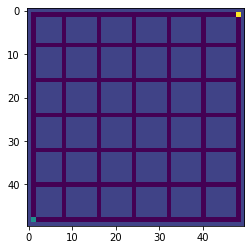

In [0]:
img = env.render()
plt.imshow(img, cmap= 'viridis')

state: 2401

 setting state to state next to goal
state: 148

 setting state to state at intersection
state: 408
state: 109

 reset environment state: 2401
[{0: [[1, 98, 100, True]], 1: [[1, 198, -1, False]], 2: [[1, 149, -50, False]], 3: [[1, 147, -50, False]]}
 {0: [[1, 358, -1, False]], 1: [[1, 458, -1, False]], 2: [[1, 409, -1, False]], 3: [[1, 407, -1, False]]}
 {0: [[1, 59, -1, False]], 1: [[1, 159, -50, False]], 2: [[1, 110, -50, False]], 3: [[1, 108, -1, False]]}
 {0: [[1, 2351, -1, False]], 1: [[1, 2451, -50, False]], 2: [[1, 2402, -1, False]], 3: [[1, 2400, -50, False]]}]
(1, 17)


Text(0.5, 1.0, 'Environment with trafic')

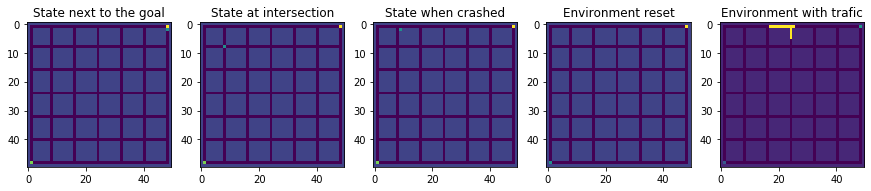

In [0]:
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)


fig, axs = plt.subplots(1,5, figsize = (15,15))
transitions_val = []

#we set a state where we are next to the goal
print("\n setting state to state next to goal")
state = (destination[0] + 1, destination[1])
state = env.encode_state(state[0],state[1])
env.state = state
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)
#print("destination:",env.goal)
#print(env.R[env.state])
transitions_val.append(env.R[env.state])
#print("transitions: ", env.R[env.state][1])
img = env.render()
axs[0].imshow(img)
axs[0].set_title("State next to the goal")

#we set a state at a intersection to check 
print("\n setting state to state at intersection")
intersect = block_width / blocks
intersect = int(intersect)
state = env.encode_state(intersect,intersect)
env.state = state
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)
transitions_val.append(env.R[env.state])
#print("destination:",env.goal)
#print(env.R[36])
img = env.render()
axs[1].imshow(img)
axs[1].set_title("State at intersection")


#we set a state where we are chrashed in a building only acceptable action is getting out of the wall (West in this case)
#print("\n setting car crash, nooo")
state = env.encode_state(2,9)
env.state = state
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)
#print("destination:",env.goal)
#print(env.R[29])
transitions_val.append(env.R[env.state])
img = env.render()
axs[2].imshow(img)
axs[2].set_title("State when crashed")

print("\n reset environment state:",env.reset())
#print("state: ", env.state)
img = env.render()
transitions_val.append(env.R[env.state])
axs[3].imshow(img)
axs[3].set_title("Environment reset")

print(np.asarray(transitions_val))

trafics = [(1,17),(1,18),(1,18),(1,19),(1,20),(1,21),(1,22),(1,22),(1,23),(1,24),(1,25),(1,25),(2,24),(3,24),(4,24),(5,24)]
print(trafics[0])
trafics_encoded = []
for i, value in enumerate(trafics):
  trafics_encoded.append(env.encode_state(value[0],value[1]))
img = env.render(trafics_encoded)
axs[4].imshow(img)
axs[4].set_title("Environment with trafic")

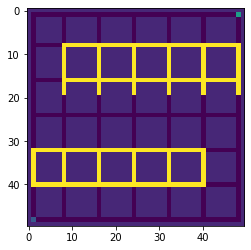

In [0]:
import copy
############### create traffic 😤😤😤 #####################
traffics = []
def create_traffic(begin_row, end_row, begin_col, end_col):
  for i in range(begin_row, end_row):
    for j in range(begin_col, end_col):
      if env.maze[i,j] == 0:
        state = env.encode_state(i,j)
        traffics.append(state)

trafic_R = copy.deepcopy(env.R)
def create_trafic_R(jam_list,reward_traffic):
  for i, value in enumerate(jam_list):
    traf = np.copy(value)
    #print("trafic_R[value]",trafic_R[value],"\n env.R", env.R[value])
    for i in range(4):
      if trafic_R[value][i][0][2] == -1:
        trafic_R[value][i][0][2] = reward_traffic
    #print("traffic_R[value]", trafic_R[value])
  return trafic_R

create_traffic(begin_row = 8, end_row = 20, begin_col = 8, end_col = 50)
create_traffic(begin_row = 32, end_row = 41, begin_col = 0, end_col = 41)
#create R for traffic
trafic_R = create_trafic_R(traffics, reward_traffic = -11)
env.trafic_R = trafic_R
# set trafic R matrix
img = env.render(traffics)
plt.imshow(img)



In [0]:
############### training #############
import time
start_time = time.time()
from IPython.display import clear_output
import random

print( 20 * "#" + " Attention resetting Q matrix " + 20 * "#")
Q = np.zeros([env.observation_space.n, env.action_space.n])
print("Q matrix shape\n",Q.shape)

alpha = 0.1
gamma = 0.6
epsilon = 0.5

epochs = []
penalties = []
average_rewards = []
steps = []

print("start state: ", env.start, "destination: ", env.goal)

for i in range(1,10000): #change this 5 to 10001
  state = env.reset()
  #print("state", state)
  epochs, penalties, reward = 0,0,0
  step_until_goal = 0
  total_reward = 0
  done = False
  
  while not done:
    if random.uniform(0,1) < epsilon: 
      action = env.action_space.sample() # explore 🧐
    else:
      action = np.argmax(Q[state]) # exploit 😈

    #print("action", action, "state", env.state)
    Prob, Next_state, Reward, Done = env.step(action)
    #print("prob:", Prob, "Next_state: ", Next_state, "reward: ", Reward, "done", Done)
    #print("We have taken action '{}' and this resulted in state '{}' with a reward '{}'".format(action, Next_state, Reward))

    old_value = Q[state,action]
    next_max = np.max(Q[Next_state])

    new_value = (1 - alpha)*old_value + alpha*(Reward + gamma + next_max)
    Q[state, action] = new_value
    
    if Reward == -10:
      penalties += 1
    total_reward += Reward
    state = Next_state
    env.state = state
    epochs += 1
    done = Done
    step_until_goal += 1
  
  
  if i % 500 == 0:
    print("Reward until destination: ", total_reward/epochs, "steps until goal", step_until_goal)
    average_rewards.append(total_reward/epochs)
    steps.append(step_until_goal)
  if i % 1000 == 0:
    print(20 * "#" + " We are Q learning rn " + 20 * "#")

print(20 * "#" + " We Finished Q learning " + 20 * "#")



#################### Attention resetting Q matrix ####################
Q matrix shape
 (2500, 4)
start state:  (48, 1) destination:  (1, 48)
Reward until destination:  -13.519553072625698 steps until goal 716
Reward until destination:  -15.527472527472527 steps until goal 273
#################### We are Q learning rn ####################
Reward until destination:  -11.949771689497718 steps until goal 219
Reward until destination:  -14.730627306273062 steps until goal 271
#################### We are Q learning rn ####################
Reward until destination:  -15.79496402877698 steps until goal 278
Reward until destination:  -13.143410852713178 steps until goal 258
#################### We are Q learning rn ####################
Reward until destination:  -15.047826086956523 steps until goal 230
Reward until destination:  -14.289285714285715 steps until goal 280
#################### We are Q learning rn ####################
Reward until destination:  -14.486792452830189 steps until goal 

In [0]:
"""Evaluate agent's performance after Q-learning"""
total_epochs, total_penalties = 0, 0
episodes = 1
frames = []
states_eval = []
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    reward_until_goal = 0
    done = False
    while not done:
        action = np.argmax(Q[state])
        Prob, Next_state, Reward, Done = env.step(action)
        if Reward == -10:
          penalties += 1
        state = Next_state
        states_eval.append(state)
        env.state = Next_state
        done = Done
        epochs += 1
        reward += Reward
        frames.append({'frame': env.render(states_eval), 'state': state, 'action': action, 'reward': reward})
    reward_until_goal += (reward/epochs)
    print("reached goal")
    total_epochs += epochs
    total_penalties += penalties

print("average reward until goal: ", reward_until_goal/episodes)
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

reached goal
average reward until goal:  0.07446808510638298
Average timesteps per episode: 94.0
Average penalties per episode: 0.0


In [0]:
 def print_frames(frames):
  steps = 0
  for i, frame in enumerate(frames):
    if i % 6 == 0:
      clear_output(wait = True)
      print(f"Timestep: {i + 1}")
      print(f"State: {frame['state']}")
      print(f"Action: {frame['action']}")
      print(f"Reward: {frame['reward']}")
      plt.imshow(frame['frame'])
      plt.show()
      sleep(1)
    steps += 1
    if env.decode_state(frame['state']) == env.goal:
      steps +=1
      print("we reached our goal")
      print(f"State: {frame['state']}")
      print(f"Action: {frame['action']}")
      print(f"Reward: {frame['reward']}")
      print(f"With: {steps} steps")
      plt.imshow(frame['frame'])
      plt.show()
      sleep(1)

    
#print_frames(frames)

In [0]:
################## train with traffic ##################

alpha = 0.1
gamma = 0.8
epsilon = 0.5

epochs = []
penalties = []
average_rewards = []
steps = []
Traffic = True
env.trafic_R = trafic_R
print("start state: ", env.start, "destination: ", env.goal)
for i in range(1,10000): #change this 5 to 10001
  if Traffic == True:
    env.R = env.trafic_R
  state = env.reset()
  #print("state", state)
  epochs, penalties, reward = 0,0,0
  step_until_goal = 0
  total_reward = 0
  done = False
  
  while not done:
    if random.uniform(0,1) < epsilon: 
      action = env.action_space.sample() # explore 🧐
    else:
      action = np.argmax(Q[state]) # exploit 😈

    #print("action", action, "state", env.state)
    Prob, Next_state, Reward, Done = env.step(action)
    #print("prob:", Prob, "Next_state: ", Next_state, "reward: ", Reward, "done", Done)
    #print("We have taken action '{}' and this resulted in state '{}' with a reward '{}'".format(action, Next_state, Reward))

    old_value = Q[state,action]
    next_max = np.max(Q[Next_state])

    #if state in traffics:
      #print("We are stuck in a trafic jam please help")
    #  Reward = -6

    new_value = (1 - alpha)*old_value + alpha*(Reward + gamma + next_max)
    Q[state, action] = new_value
    
    if Reward == -10:
      penalties += 1
    total_reward += Reward
    state = Next_state
    env.state = state
    epochs += 1
    done = Done
    step_until_goal += 1
  
  
  if i % 250 == 0:
    print("Reward until destination: ", total_reward/epochs, "steps until goal", step_until_goal)
    average_rewards.append(total_reward/epochs)
    steps.append(step_until_goal)
  if i % 1000 == 0:
    print(20 * "#" + " We Q learning rn " + 20 * "#")

print(20 * "#" + " We Finished Q learning " + 20 * "#")
average_steps = np.sum(steps)/len(steps)
print("average steps",average_steps)



start state:  (48, 1) destination:  (1, 48)
Reward until destination:  -15.609098567818029 steps until goal 3561
Reward until destination:  -14.351194786386676 steps until goal 1381
Reward until destination:  -16.915673693858846 steps until goal 1091
Reward until destination:  -15.232558139534884 steps until goal 645
#################### We Q learning rn ####################
Reward until destination:  -16.46474358974359 steps until goal 624
Reward until destination:  -15.006535947712418 steps until goal 612
Reward until destination:  -15.597682119205299 steps until goal 604
Reward until destination:  -15.52280701754386 steps until goal 570
#################### We Q learning rn ####################
Reward until destination:  -17.020676691729324 steps until goal 532
Reward until destination:  -13.970338983050848 steps until goal 472
Reward until destination:  -13.195652173913043 steps until goal 506
Reward until destination:  -14.886973180076629 steps until goal 522
#################### 

In [0]:
#### evaluate with traffic ######
total_epochs, total_penalties = 0, 0
episodes = 1
frames = []
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    reward_until_goal = 0
    done = False
    states_eval = []
    while not done:
        action = np.argmax(Q[state])
        Prob, Next_state, Reward, Done = env.step(action)
        if Reward == -10:
          penalties += 1
        state = Next_state
        states_eval.append(state)
        env.state = Next_state
        done = Done
        epochs += 1
        reward += Reward
        frames.append({'frame': env.render(traffics,states_eval), 'state': state, 'action': action, 'reward': reward})
    reward_until_goal += (reward/epochs)
    print("reached goal")
    total_epochs += epochs
    total_penalties += penalties

print("average reward until goal: ", reward_until_goal/episodes)
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

reached goal
average reward until goal:  -0.4627659574468085
Average timesteps per episode: 188.0
Average penalties per episode: 0.0


Timestep: 187
State: 97
Action: 2
Reward: -187


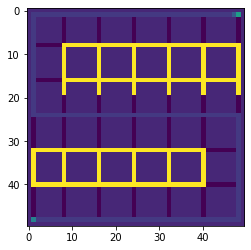

we reached our goal
State: 98
Action: 2
Reward: -87
With: 189 steps


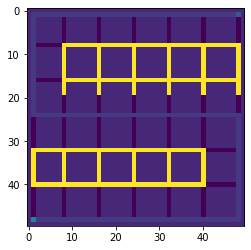

In [0]:
print_frames(frames)